# Analyse Experiment Data 6

With pressure sensor parascientific and new speaer 

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
config = {}

1 Trace(s) in Stream:
.munki1..p1s32 | 2022-09-25T23:43:50.069720Z - 2022-09-26T22:35:14.019720Z | 20.0 Hz, 1645680 samples


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/core/trace.py:220: UserWarning: Calibration factor set to 0.0!
  warnings.warn(msg, UserWarning)


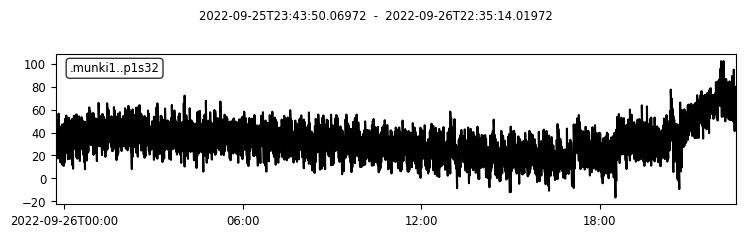

In [6]:
config['datapath_femto'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/femto/experiment6/"

config['outpath_mseed'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/mseed/"

## read data stream using obspy routine
st = obs.read(config['datapath_femto']+"munki1_269_css.wfdisc", format="CSS")

## merge traces that might be split due to data gaps or overlaps
st.merge(fill_value="interpolate")

## setting the calibration variable if not already set
st[0].stats.calib = 1.0

## show all traces in data stream
print(st)

st.plot(equal_scale=False);

## Experiment Valve Open

Read pressure data

In [7]:
config['datapath_pressure'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/pressure/"

In [8]:
## read data of parascientific barometer
pressure = pd.read_csv(config['datapath_pressure']+"DATA7.txt", names=["timestamp","pressure"])

## convert timestamp to datetime objects
pressure['timestamp'] = pd.to_datetime(pressure.timestamp)

## make local time to UTC (+7 hours)
pressure['timestamp'] += pd.to_timedelta(7, unit='h')

## resample with df=1sec
pressure = pressure.resample("1S", on="timestamp").mean().reset_index()

pressure

timestamp    pressure
0    2022-09-26 20:37:55  100.205500
1    2022-09-26 20:37:56  101.073850
2    2022-09-26 20:37:57  100.715367
3    2022-09-26 20:37:58  100.979400
4    2022-09-26 20:37:59  100.823933
...                  ...         ...
9328 2022-09-26 23:13:23  100.575200
9329 2022-09-26 23:13:24  100.820550
9330 2022-09-26 23:13:25  100.583250
9331 2022-09-26 23:13:26  100.804400
9332 2022-09-26 23:13:27   99.944800

[9333 rows x 2 columns]

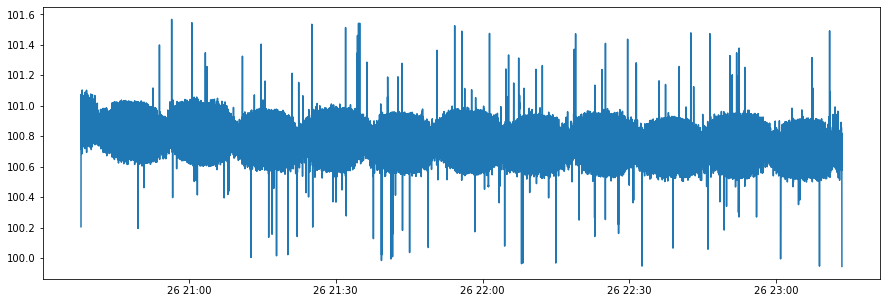

In [9]:
plt.figure(figsize=(15,5))
plt.plot(pressure.timestamp, pressure.pressure)

In [10]:
pressure_trace = obs.Trace()

pressure_trace.data = np.array(pressure.pressure)
pressure_trace.stats.starttime = obs.UTCDateTime(pressure.timestamp[0])
pressure_trace.stats.delta = 1.0
pressure_trace.stats.station = "BARO"
pressure_trace.stats.channel = "XXX"

pressure_trace

.BARO..XXX | 2022-09-26T20:37:55.000000Z - 2022-09-26T23:13:27.000000Z | 1.0 Hz, 9333 samples

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


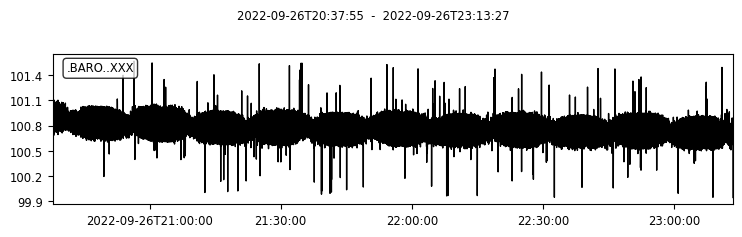

In [11]:
pressure_trace.plot();

Text(0, 0.5, 'Pressure (kPa)')

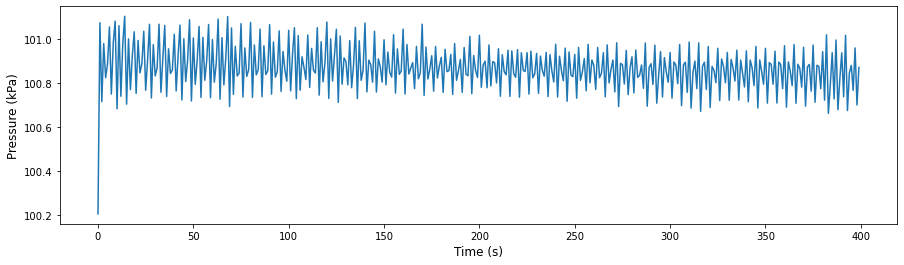

In [12]:
plt.figure(figsize=(15,4))
plt.plot(pressure_trace.data[:400])
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Pressure (kPa)", fontsize=12)

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


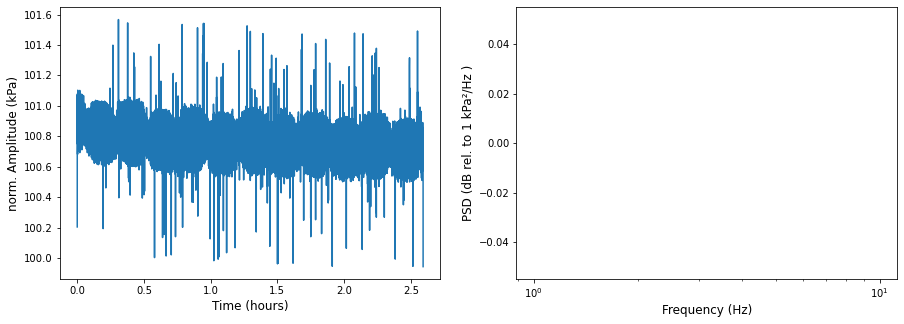

In [13]:
def __plot_psd(trace):

    from scipy.signal import welch, hann


    signal = trace.data 
    
    nblock =  512
    overlap = None
    # window = hann(int(nblock))

    f, Pxx = welch(signal, fs=trace.stats.sampling_rate, 
                    window='hann', noverlap=overlap, nperseg=nblock,
                    scaling="density",
                    return_onesided=True)

    ## normalize
    # Pxx /= nblock

    
    Pxx /= max(Pxx)
    Pxx = 10*np.log10(Pxx)

    
    ## ------------------------

    font = 12

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    tx = np.linspace(0, trace.stats.npts/trace.stats.sampling_rate/3600, trace.stats.npts)
    ax[0].plot(tx, signal)

    ax[1].vlines(0.120, min(Pxx), max(Pxx), color="grey", ls="--", alpha=1, zorder=0)
    ax[1].semilogx(f, Pxx)

#     ax[1].set_ylim(-80,5)
#     ax[1].set_xlim(1e-3,5)

    ax[0].set_xlabel("Time (hours)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_ylabel("norm. Amplitude (kPa)", fontsize=font)
    ax[1].set_ylabel("PSD (dB rel. to 1 kPa²/Hz )", fontsize=font)

    plt.show();
    
__plot_psd(pressure_trace)

## Cut to actual experiment times

Mind the difference between local time and UTC (+7 hours)

In [14]:
t1 = obs.UTCDateTime("2022-09-26 11:35") + 7*3600
t2 = obs.UTCDateTime("2022-09-26 13:35") + 7*3600
outname = "experiment6"
print(t1,t2)

t1 = obs.UTCDateTime("2022-09-26 13:45") + 7*3600
t2 = obs.UTCDateTime("2022-09-26 15:15") + 7*3600
outname = "experiment7"
print(t1,t2)

2022-09-26T18:35:00.000000Z 2022-09-26T20:35:00.000000Z
2022-09-26T20:45:00.000000Z 2022-09-26T22:15:00.000000Z


In [15]:
st2 = st.copy()


## add pressure trace
st2 += pressure_trace


st2.trim(t1, t2)

## write to mseed files
st2.write("")

def __make_plot_traces():

    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)

    fig.subplots_adjust(hspace=0)

    ax[0].plot(st2.select(station="BARO")[0].times()/3600, st2.select(station="BARO")[0].data)
    ax[1].plot(st2.select(station="munki1")[0].times()/3600, st2.select(station="munki1")[0].data)

    plt.xlabel("Time (hours)", fontsize=12)
    ax[0].set_ylabel("Pressure (kPa)", fontsize=12)
    ax[1].set_ylabel("Phase (rad)", fontsize=12)

__make_plot_traces()

ValueError: Writing format "" is not supported. Supported types: MSEED, SAC, GSE2, SACXY, Q, SH_ASC, SLIST, TSPAIR, PICKLE, SEGY, SU, WAV, AH

In [16]:

# st2.detrend('polynomial', order=2)

# st2.taper(0.1)
# st2.filter('highpass', freq=0.1, corners=4, zerophase=True)

# st2.plot(equal_scale=False);

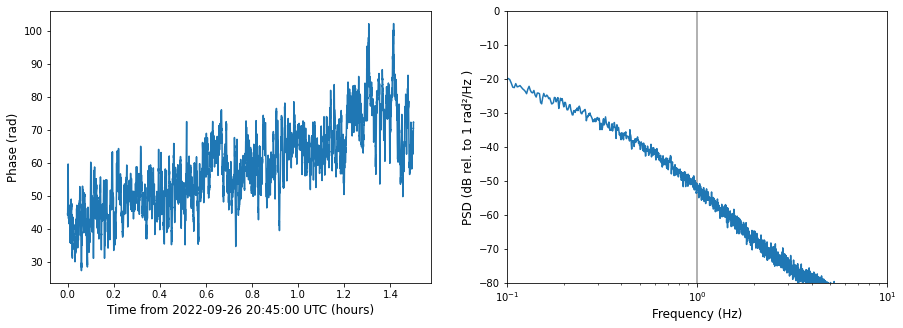

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 10240 is greater than input length  = 5401, using nperseg = 5401
  .format(nperseg, input_length))


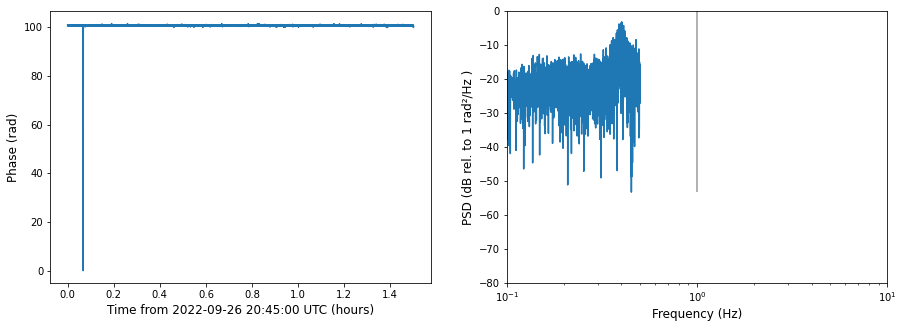

In [17]:
def __plot_psd(trace):

    from scipy.signal import welch, hann


    signal = trace.data

    signal = [el if not np.isnan(el) else 0 for el in signal ]
    
    tstart = trace.stats.starttime
    
    nblock =  512 *20
    overlap = None
    # window = hann(int(nblock))

    f, Pxx = welch(signal, fs=trace.stats.sampling_rate, 
                    window='hann', noverlap=overlap, nperseg=nblock,
                    scaling="density",
                    return_onesided=True)
    ## normalize
    # Pxx /= nblock

    Pxx /= max(Pxx)
    Pxx = 10*np.log10(Pxx)


    ## ------------------------

    font = 12

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    tx = np.linspace(0, trace.stats.npts/trace.stats.sampling_rate/3600, trace.stats.npts)
    ax[0].plot(tx, signal)

    ax[1].vlines(1.0006, min(Pxx), max(Pxx), color="grey", ls="-", alpha=0.8, zorder=0)
    ax[1].plot(f, Pxx)

    
    ax[1].set_xscale("log")
    ax[1].set_ylim(-80,0)
    ax[1].set_xlim(1e-1,10)

    ax[0].set_xlabel(f"Time from {tstart.date} {str(tstart.time)[:8]} UTC (hours)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_ylabel("Phase (rad)", fontsize=font)
    ax[1].set_ylabel("PSD (dB rel. to 1 rad²/Hz )", fontsize=font)

    plt.show();
    
__plot_psd(st2.select(station="munki1")[0])
__plot_psd(st2.select(station="BARO")[0])

In [ ]:
from andbro__get_mean_amplitude import __get_mean_amplitude

signal = pressure_trace.data

amps, amps_mean, amps_std = __get_mean_amplitude(signal, deltaN=100)

amps_mean, amps_std